### Possible Bugs
- does inception model normalize? are you normalizing twice?


In [1]:
import re, pickle, collections, bcolz, numpy as np, keras, sklearn, math, operator, pdb

from gensim.models import word2vec, KeyedVectors
import torch, torch.nn as nn
from torch.autograd import Variable
from torch import optim
from torchvision.models import inception_v3
import torch.nn.functional as F
from keras.preprocessing.sequence import pad_sequences
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
import re
from os import path
from glob import glob
from torch.utils.data import DataLoader
from PIL import Image
%matplotlib inline


Using TensorFlow backend.


In [2]:
dpath = '/data/image_captioning/flikr8/'
imgpath =  '/data/image_captioning/flikr8/Flicker8k_Dataset/' 
tr_img_path = imgpath +'train/'
embed_path = '/data/word_embed/glove.6B.300d.txt'
BATCH_SIZE=4
MAX_LEN=30

In [3]:
tr_caps = pickle.load(open(dpath+'train_first_caps.pkl', 'rb'))
#pickle.dump(qs, open(dpath+'fr-en-qs.pkl', 'wb'))

In [4]:
tr_caps[0]

('1000268201_693b08cb0e.jpg',
 'A child in a pink dress is climbing up a set of stairs in an entry way .')

In [5]:
re_apos = re.compile(r"(\w)'s\b")         # make 's a separate word
re_mw_punc = re.compile(r"(\w[’'])(\w)")  # other ' in a word creates 2 words
re_punc = re.compile("([\"().,;:/_?!—])") # add spaces around punctuation
re_mult_space = re.compile(r"  *")        # replace multiple spaces with just one

def simple_toks(sent):
    sent = re_apos.sub(r"\1 's", sent)
    sent = re_mw_punc.sub(r"\1 \2", sent)
    sent = re_punc.sub(r" \1 ", sent).replace('-', ' ')
    sent = re_mult_space.sub(' ', sent)
    return sent.lower().split()

In [6]:
tokens = {name: simple_toks(words) for name, words in tr_caps}
keys = list(tokens.keys()); tokens[keys[0]]

['a',
 'child',
 'in',
 'a',
 'pink',
 'dress',
 'is',
 'climbing',
 'up',
 'a',
 'set',
 'of',
 'stairs',
 'in',
 'an',
 'entry',
 'way',
 '.']

In [7]:
PAD = 0; SOS = 1; EOS = 2
def toks2ids(sents):
    #create new counter from all tokens in all lines
    sents_vals = list(sents.values())
    voc_cnt = collections.Counter(t for sent in sents_vals for t in sent) 
    
    #sort vocab in reverse order
    vocab = sorted(voc_cnt, key=voc_cnt.get, reverse=True)
    
    vocab.insert(PAD, "<PAD>")
    vocab.insert(SOS, "<SOS>")
    vocab.insert(EOS, "<EOS>")
    # {word: index of word}
    w2id = {w:i for i,w in enumerate(vocab)}
    #make each sentence into a list of ids
    ids = [[w2id[t] for t in sent] for sent in sents_vals]
    name_ids_dict = {name: id_vals for name, id_vals in zip(sents.keys(), ids)}
    return ids, vocab, w2id, voc_cnt, name_ids_dict

In [8]:
ids, vocab, w2id, counts, name_ids_dict = toks2ids(tokens)
id2w = {v: k for k, v in w2id.items()}

a child in a pink dress is climbing up a set of stairs in an entry way .


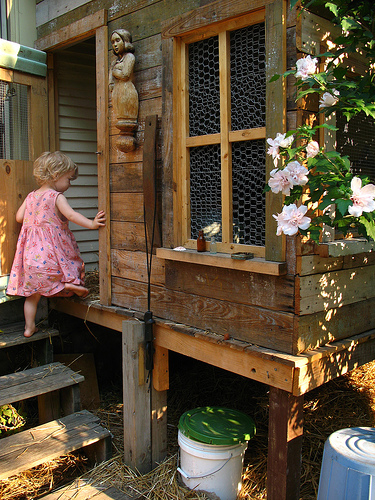

In [9]:
def turnId2W(ids):
    return ' '.join([id2w[id] for id in ids])
names_from_dict = list(name_ids_dict.keys())

print(turnId2W(name_ids_dict[names_from_dict[0]]))
Image.open(tr_img_path+'wrap/'+ names_from_dict[0])


## Word vectors

In [10]:
def load_glove_me(loc):
    w2v = {}
    for line in open(loc):
        l = line.split()
        w2v[l[0]] = np.array(l[1:], dtype=np.float32)
    return w2v

In [11]:
w2v = load_glove_me(embed_path)
n_en_vec = len(w2v.keys()) #number of words encoded
dim_en_vec = len(w2v['the']) #dimension of embeddings -- we just use 'the' as a way to get it.

In [13]:
w2v['king'][:10]

array([ 0.0033901 , -0.34614   ,  0.28143999,  0.48381999,  0.59469002,
        0.012965  ,  0.53982002,  0.48232999,  0.21462999, -1.02489996], dtype=float32)

In [14]:
def create_emb_mat(w2v, targ_vocab, dim_vec):
    vocab_size = len(targ_vocab)
    emb = np.zeros((vocab_size, dim_vec)) #initialize empty container
    found=0
    for i, word in enumerate(targ_vocab): 
        try: emb[i] = w2v[word]; found+=1 #if we find it, use the word's vecotrs
        except KeyError: emb[i] = np.random.normal(scale=0.6, size=(dim_vec,)) #else randomeness

    return emb, found

In [15]:
embs, found = create_emb_mat(w2v, vocab, dim_en_vec); embs.shape, found

((3821, 300), 3690)

## Prep data

In [16]:
lens = sorted(list(map(len, ids))); lens[-1]

35

In [17]:
maxlen = 30
def padAndEOS(ids, maxlen=MAX_LEN):
    ids = list(map(lambda x:  x + [EOS], ids))
    return pad_sequences(ids, maxlen+2, 'int64', "post", "post")
    padded = padAndEOS(ids)
padded = padAndEOS(ids)
turnId2W(padded[0])

'a child in a pink dress is climbing up a set of stairs in an entry way . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'

## Data Loading

In [18]:
mu = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
scaleCrop = transforms.Compose([transforms.Scale(299), transforms.CenterCrop((299, 299))])

norm = transforms.Normalize(mean=mu,std=std)
mu_rev = torch.FloatTensor(mu).unsqueeze(1).unsqueeze(1)
std_rev = torch.FloatTensor(std).unsqueeze(1).unsqueeze(1)
preproc = transforms.Compose([scaleCrop, transforms.ToTensor(), norm])
denorm = transforms.Lambda(lambda x: (x * torch.FloatTensor(std_rev)) + torch.FloatTensor(mu_rev))
revTrans = transforms.Compose([denorm, transforms.ToPILImage()])
tr_ds = ImageFolder(imgpath+'train/', transform=preproc)
tr_dl = DataLoader(tr_ds,batch_size=BATCH_SIZE)

def long_t(arr): return Variable(torch.LongTensor(arr)) #.cuda()


In [81]:
def ImgCapLoader(dl, caps_dict, batch_size=BATCH_SIZE, shuffle=True):
    if shuffle:
        dl.dataset.imgs = [(path, int(clazz)) for path, clazz in np.random.permutation(dl.dataset.imgs)]
    img_names = dl.dataset.imgs
    num_batches = len(img_names) // batch_size
    dl_iter = dl.__iter__()
    for i in range(0, len(img_names), batch_size):
        basenames = [path.basename(name) for name, clz in img_names[i:i+batch_size]]
        ids = np.vstack(padAndEOS([caps_dict[name] for name in basenames]))
        imgs, _ = dl_iter.__next__()
        yield imgs, ids

### Training

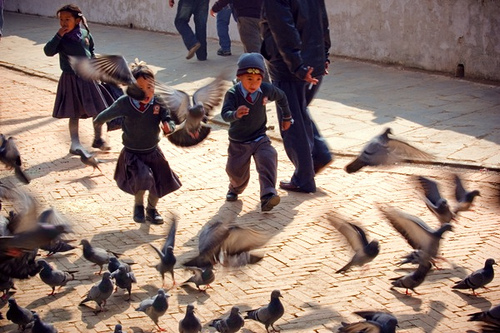

In [74]:
samp_img_path = imgpath+'samp/'
samp_imgs = list(map(path.basename, glob(samp_img_path+'/wrap/*.jpg')))
samp_dict = {name:ids for name, ids in name_ids_dict.items() if name in samp_imgs}
Image.open(samp_img_path+'/wrap/'+samp_imgs[3])

In [21]:
[turnId2W(ids) for name, ids in samp_dict.items()]

['a bulldog , a sheep dog , and a boxer standing in a yard .',
 'adults , and children in school uniforms , move through a flock of pigeons .',
 'a lady stands in a field of tulips looking unamused .',
 'a boy does a trick on a skateboard .']

In [80]:
samp_ds = ImageFolder(samp_img_path, transform=preproc)
samp_dl = DataLoader(samp_ds,batch_size=BATCH_SIZE)


In [145]:
def create_emb_layer(emb_mat, non_trainable=False):
    output_size, emb_size = emb_mat.size() # get size
    emb = nn.Embedding(output_size, emb_size) #lookup table for embeddings
    emb.load_state_dict({'weight': emb_mat}) #load pretrained embeddings into embedding lookup
    if non_trainable:
        for param in emb.parameters(): 
            param.requires_grad = False
    return emb, emb_size, output_size

class Encoder(nn.Module):
    def __init__(self, batch_size=4, emb_size=300, pool_size=8, fc_in_size=2048, testing=False):
        super(Encoder, self).__init__()
        self.batch_size=batch_size
        self.poolInput = nn.AvgPool2d(pool_size)
        self.toEmbed = nn.Linear(fc_in_size, emb_size, bias=False)
        self.cnn = inception_v3(pretrained=True)
        for param in self.cnn.parameters(): 
            param.requires_grad = False
        if testing:
            self.cnn.eval()

        targ_layer = self.cnn._modules.get('Mixed_7c')
        self.out = torch.zeros([batch_size, fc_in_size, pool_size, pool_size])
        def fun(m, i, o): self.out.copy_(o.data)
        self.h = targ_layer.register_forward_hook(fun)
        
    def forward(self, x):
        _ = self.cnn(x)
        x = self.poolInput(self.out)
        x = x.view(self.batch_size, -1)
        return self.toEmbed(x)
        

class Decoder(nn.Module):
    def __init__(self, embeds, num_layers=1):
        super(Decoder, self).__init__()
        self.embed, self.emb_size, self.output_size = create_emb_layer(embeds, non_trainable=True)
        self.gru = nn.GRU(input_size=self.emb_size, hidden_size=self.emb_size, num_layers=num_layers)
        self.out = nn.Linear(self.emb_size, self.output_size)
    
    def forward(self, input, hidden):
        x = self.embed(input)
        x, hidden = self.gru(x.unsqueeze(0), hidden)
        return F.log_softmax(self.out(x.squeeze(0))), hidden

In [59]:
def trainFor(enc, enc_opt, dec, dec_opt, img_dl, cap_dict, epochs=10000, print_every=25):
    for epoch in range(epochs):
        gen = ImgCapLoader(img_dl, cap_dict)
        loss = train(gen, enc, enc_opt, dec, dec_opt)
        #print(epoch)
        #print(loss)
        if epoch % print_every == 0:
            print('epoch {} loss: {}'.format(epoch, loss.data[0]))


def train(loader, enc, enc_opt, dec, dec_opt, crit=nn.NLLLoss()):
    for imgs, ids in loader:
        enc_opt.zero_grad; dec_opt.zero_grad()
        loss = 0.0
        targ_len = ids.shape[1]
        ids = Variable(torch.LongTensor(ids))
        dec_input = long_t([SOS]*imgs.size()[0])
        hidden = enc(Variable(imgs)).unsqueeze(0)
        for di in range(targ_len):
            dec_output, hidden = dec(dec_input, hidden) #get output hidden
            dec_input = ids[:, di] #next decoder input (teacher forcing)
            #pdb.set_trace()
            loss += crit(dec_output, dec_input) #compute loss
        
        loss.backward()
        enc_opt.step()
        dec_opt.step()
        
    return loss

def getCaps(ids):
    caps = []
    for i in ids:
        caps.append(turnId2W(i))
        #print()
        #print("\n")
    return caps


In [60]:
enc_opt=torch.optim.SGD(filter(lambda p: p.requires_grad, enc.parameters()), lr=0.001) 
dec_opt=torch.optim.SGD(filter(lambda p: p.requires_grad, enc.parameters()), lr=0.001)
trainFor(enc, enc_opt, dec, dec_opt, samp_dl, samp_dict)

epoch 0 loss: 13.076720237731934
epoch 25 loss: 12.80217456817627


KeyboardInterrupt: 

torch.save(enc.state_dict(),'models/samp_enc.pt')
torch.save(dec.state_dict(),'models/samp_dec.pt')


In [118]:
def evaluate(enc, dec, img_dl, cap_dict):
    loader = ImgCapLoader(img_dl, cap_dict, shuffle=False)  
    for imgs, ids in loader:
        print(turnId2W(ids[2,:]))
        targ_len = ids.shape[1]
        ids = Variable(torch.LongTensor(ids))
        dec_input = long_t([SOS]*imgs.size()[0])
        hidden = enc(Variable(imgs)).unsqueeze(0)
        outs = []        
        for di in range(targ_len):
            dec_output, hidden = dec(dec_input, hidden) 
            _, dec_input = dec_output.topk(1)
            dec_input = dec_input.squeeze(1)
            outs.append(dec_input.data.numpy())
        break
    return np.vstack(outs).T

### Beam Search

In [178]:
enc = Encoder(batch_size=1, testing=True)
embs_t = torch.FloatTensor(embs)
dec = Decoder(embs_t)
enc.load_state_dict(torch.load('models/samp_enc.pt'))
dec.load_state_dict(torch.load('models/samp_dec.pt'))

/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/torchvision-0.1.9-py3.6.egg/torchvision/models/inception.py:65: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  m.weight.data.copy_(values)


In [214]:
beam_img_path= samp_img_path+'wrap/'+samp_imgs[3];beam_img_path
beam_img = Image.open(beam_img_path); beam_img
beam_img_proc = preproc(beam_img).unsqueeze(0); beam_img_proc.size()

torch.Size([1, 3, 299, 299])

In [215]:
def checkBeam(cands):
    ids = list(map(lambda c: torch.cat(c['i']).data.numpy(), cands))
    prs = list(map(lambda c: c['pr'].data[0], cands))
    caps = map(lambda i: turnId2W(i), ids)
    return list(caps), prs

In [216]:
def beam_search(enc, dec, inp, targ_len=32, beam=2, SOS=SOS, EOS=EOS):
    totSol = []
    long_t = lambda x: Variable(torch.LongTensor(x))
    hidden = enc(Variable(inp)).unsqueeze(0)
    start = {'pr':1.0, 'i': [long_t([SOS])], 'h': hidden}
    cands = [start]
    for ts in range(targ_len):
        temp_cands = []
        for c in cands:
            o, h = dec(c['i'][-1], c['h'])
            top_p, top_i = torch.topk(o, beam)
            for t in range(top_p.size()[1]):    
                tc = {'pr': top_p[:, t] + c['pr'], 'i': c['i'][:] + [top_i[:, t]], 'h': h}
                if tc['i'][-1].data[0] == EOS:
                    totSol.append(tc)
                else:
                    temp_cands.append(tc)
        temp_cands = sorted(temp_cands, key=lambda x: x['pr'].data[0], reverse=True)
        #print(checkBeam(temp_cands))
        cands = temp_cands[:beam]

    all_sol = cands + totSol
    all_sol =  sorted(all_sol, key=lambda x: x['pr'].data[0], reverse=True)
    top_caps, _ = checkBeam(all_sol)
    return all_sol, top_caps
        

In [217]:
o, c = beam_search(enc, dec, beam_img_proc, beam=3)